# **HIPOTESIS 1**

H1. Los hombres consumen más estupefacientes que las mujeres en todos los grupos de edad y en todos los paises

📌 Problema que se aborda: diferencia de la prevalencia de consumo por grupo de edad, por género y por tipo de estupefaciente

Análisis que hacemos: cantidad qu consumen hombrees y mujeres, cantidad que consumen por grupo de edad, relaciones entre consumo y genero, relacion entre consumo y grupo de edad, analisis de que tipo de droga consumen mas por genero y que tipo de droga consumen mas por edad

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats

In [9]:
df_drugs = pd.read_csv("../data/data_clean/drugs.csv", index_col=0)
df_drugs_no_na = pd.read_csv("../data/data_clean/drugs_no_na.csv", index_col=0)

### ESCONDER - son las funciones de base

In [10]:
# ===================
# Funciones que voy a usar para análisis univariante
# las pongo colapsadas para que no ocupen mucho
# ===================

# Función que calcula la cardinalidad y el tipo de variable
def cardinalidad(df_in, umbral_categoria = 10, umbral_continua = 30):

    resultado = []
    for col in df_in.columns:
        card = df_in[col].nunique()
        porc_card = df_in[col].nunique()/len(df_in) * 100
        tipo = df_in[col].dtypes
        if card == 2:
            clasif = "Binaria"
        elif card < umbral_categoria:
            clasif = "Categórica"
        elif card >= umbral_categoria:
            if porc_card >= umbral_continua:
                clasif = "Numérica Continua"
            else:
                clasif = "Numérica Discreta"

        # Añadimos los resultados a la lista
        resultado.append({
            "columna": col,
            "tipo": tipo,
            "cardinalidad": card,
            "porcentaje_card": porc_card,
            "clasificacion": clasif
        })
    
    # Convertimos la lista de dicts en dataframe
    df_resul = pd.DataFrame(resultado)
        
    return df_resul

# 3. Función que representa las frecuencias absolutas o relativas en gráficos
def pinta_distribucion_categoricas(df, columnas_categoricas, relativa=False, mostrar_valores=False):
    num_columnas = len(columnas_categoricas)
    num_filas = (num_columnas // 2) + (num_columnas % 2)

    fig, axes = plt.subplots(num_filas, 2, figsize=(15, 5 * num_filas))
    axes = axes.flatten() 

    for i, col in enumerate(columnas_categoricas):
        ax = axes[i]
        if relativa:
            total = df[col].value_counts().sum()
            serie = df[col].value_counts().apply(lambda x: x / total)
            sns.barplot(x=serie.index, y=serie, ax=ax, palette='viridis', hue = serie.index, legend = False)
            ax.set_ylabel('Frecuencia Relativa')
        else:
            serie = df[col].value_counts()
            sns.barplot(x=serie.index, y=serie, ax=ax, palette='viridis', hue = serie.index, legend = False)
            ax.set_ylabel('Frecuencia')

        ax.set_title(f'Distribución de {col}')
        ax.set_xlabel('')
        ax.tick_params(axis='x', rotation=45)

        if mostrar_valores:
            for p in ax.patches:
                height = p.get_height()
                ax.annotate(f'{height:.2f}', (p.get_x() + p.get_width() / 2., height), 
                            ha='center', va='center', xytext=(0, 9), textcoords='offset points')

    for j in range(i + 1, num_filas * 2):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

def columnas_numericas(df):
    num_col = df.describe().columns.to_list()
    return num_col

# Función para representar boxplots de columnas numéricas
def plot_multiple_boxplots(df, columns, dim_matriz_visual = 2):
    num_cols = len(columns)
    num_rows = num_cols // dim_matriz_visual + num_cols % dim_matriz_visual
    fig, axes = plt.subplots(num_rows, dim_matriz_visual, figsize=(12, 6 * num_rows))
    axes = axes.flatten()

    for i, column in enumerate(columns):
        if df[column].dtype in ['int64', 'float64']:
            sns.boxplot(data=df, x=column, ax=axes[i])
            axes[i].set_title(column)

    # Ocultar ejes vacíos
    for j in range(i+1, num_rows * 2):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

def plot_histo_dens(df, columns, bins=None):
    num_cols = len(columns)
    num_rows = num_cols // 2 + num_cols % 2
    fig, axes = plt.subplots(num_rows, 2, figsize=(12, 6 * num_rows))
    axes = axes.flatten()

    for i, column in enumerate(columns):
        if df[column].dtype in ['int64', 'float64']:
            if bins:
                sns.histplot(df[column], kde=True, ax=axes[i], bins=bins)
            else:
                sns.histplot(df[column], kde=True, ax=axes[i])
            axes[i].set_title(f'Histograma y KDE de {column}')

    # Ocultar ejes vacíos
    for j in range(i + 1, num_rows * 2):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Función que representa el histograma y el boxplot de varias variables
def plot_combined_graphs(df, columns, whisker_width=1.5):
    num_cols = len(columns)
    if num_cols:
        
        fig, axes = plt.subplots(num_cols, 2, figsize=(12, 5 * num_cols))
        print(axes.shape)

        for i, column in enumerate(columns):
            if df[column].dtype in ['int64', 'float64']:
                # Histograma y KDE
                sns.histplot(df[column], kde=True, ax=axes[i,0] if num_cols > 1 else axes[0])
                if num_cols > 1:
                    axes[i,0].set_title(f'Histograma y KDE de {column}')
                else:
                    axes[0].set_title(f'Histograma y KDE de {column}')

                # Boxplot
                sns.boxplot(x=df[column], ax=axes[i,1] if num_cols > 1 else axes[1], whis=whisker_width)
                if num_cols > 1:
                    axes[i,1].set_title(f'Boxplot de {column}')
                else:
                    axes[1].set_title(f'Boxplot de {column}')

        plt.tight_layout()
        plt.show()

### **ANÁLISIS UNIVARIANTE**

ESTAS FUNCIONES LAS HA HECHO LUCIA:

In [11]:
df_drugs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1043 entries, 0 to 1042
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country         1043 non-null   object 
 1   survey_year     1043 non-null   int64  
 2   prevalence_(%)  1043 non-null   float64
 3   substance       1043 non-null   object 
 4   recall_period   1043 non-null   object 
 5   age             1043 non-null   object 
 6   sample_size     950 non-null    float64
 7   males_(%)       1017 non-null   float64
 8   females_(%)     1001 non-null   float64
 9   gender_gap      1001 non-null   float64
dtypes: float64(5), int64(1), object(4)
memory usage: 89.6+ KB


In [38]:
df_drugs.describe()

,survey_year,prevalence_(%),sample_size,males_(%),females_(%),gender_gap
count,1043.000000,1043.000000,950.000000,1017.000000,1001.000000,1001.000000
mean,2018.776606,17.558581,4260.586316,19.904621,15.596803,4.624276
std,2.174479,26.759251,4568.853108,28.697494,25.437743,6.281016
min,2008.000000,0.000000,442.000000,0.000000,0.000000,-4.000000
25%,2018.000000,0.600000,1572.000000,0.800000,0.300000,0.400000
50%,2019.000000,2.800000,2957.000000,3.900000,1.800000,1.900000
75%,2020.000000,26.150000,4994.000000,32.000000,21.300000,6.600000
max,2022.000000,98.900000,26344.000000,99.600000,98.200000,38.400000


In [40]:
df_drugs["age"].describe()

count               1043
unique                 2
top       Adults (15-64)
freq                 528
Name: age, dtype: object

In [18]:
categorical_cols = [
    "country",    
    "substance",
    "recall_period",
    "age",
    "males_(%)",
    "females_(%)"
]

In [30]:
#CONTEO DE VALORES ABSOLUTOS
for catego in categorical_cols:
	print(f"Para {catego}")
	print(df_drugs[catego].value_counts())
	print("/n"*2)

Para country
country
Austria        42
Bulgaria       42
Croatia        42
Cyprus         42
Germany        42
Portugal       42
Romania        42
Italy          42
Slovakia       42
Ireland        42
Latvia         41
Czechia        40
Lithuania      40
Hungary        38
Finland        38
Türkiye        38
Poland         36
Estonia        36
Spain          36
Luxembourg     36
Netherlands    34
Slovenia       34
Greece         32
Denmark        30
France         30
Norway         30
Sweden         22
Belgium        20
Malta          12
Name: count, dtype: int64
/n/n
Para substance
substance
Cannabis        171
Cocaine         159
Ecstasy         159
Amphetamines    149
LSD             148
Alcohol         132
Tobacco         125
Name: count, dtype: int64
/n/n
Para recall_period
recall_period
Last year     367
Lifetime      348
Last month    328
Name: count, dtype: int64
/n/n
Para age
age
Adults (15-64)          528
Young adults (15-34)    515
Name: count, dtype: int64
/n/n
Para males_(

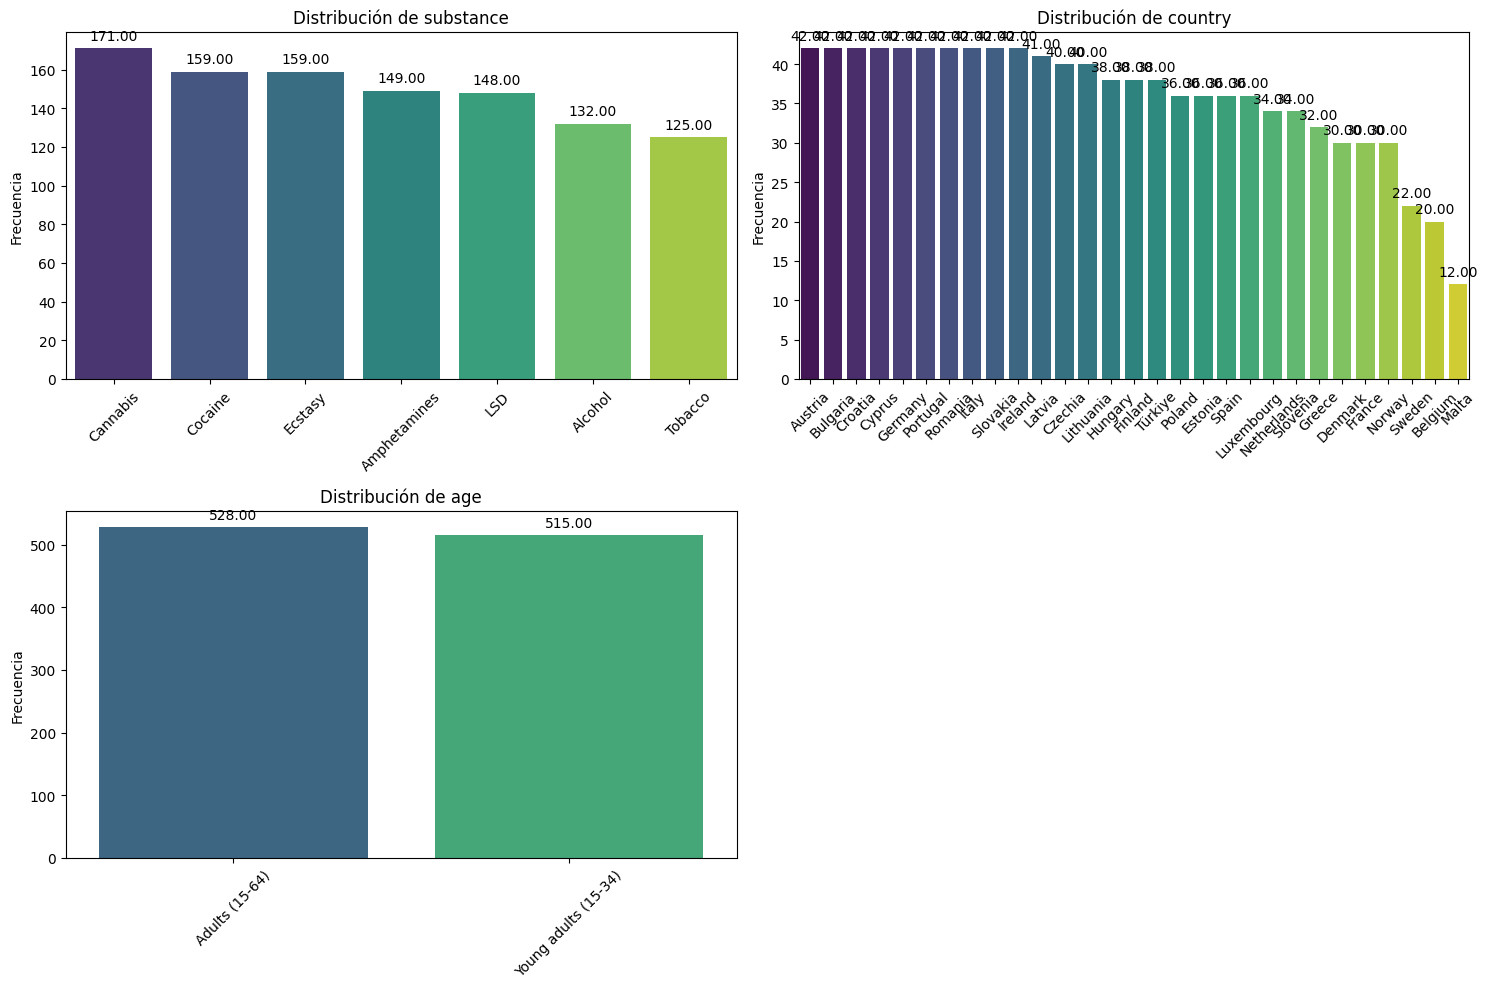

In [34]:
pinta_distribucion_categoricas(df_drugs, ["substance", "country", "age"], relativa=False, mostrar_valores=True)

In [33]:
#VALORES RELATIVOS
for catego in categorical_cols:
	print(f"Para {catego}")
	print(df_drugs[catego].value_counts()/len(df_drugs)*100)
	print("/n"*2)

Para country
country
Austria        4.026846
Bulgaria       4.026846
Croatia        4.026846
Cyprus         4.026846
Germany        4.026846
Portugal       4.026846
Romania        4.026846
Italy          4.026846
Slovakia       4.026846
Ireland        4.026846
Latvia         3.930968
Czechia        3.835091
Lithuania      3.835091
Hungary        3.643337
Finland        3.643337
Türkiye        3.643337
Poland         3.451582
Estonia        3.451582
Spain          3.451582
Luxembourg     3.451582
Netherlands    3.259827
Slovenia       3.259827
Greece         3.068073
Denmark        2.876318
France         2.876318
Norway         2.876318
Sweden         2.109300
Belgium        1.917546
Malta          1.150527
Name: count, dtype: float64
/n/n
Para substance
substance
Cannabis        16.395014
Cocaine         15.244487
Ecstasy         15.244487
Amphetamines    14.285714
LSD             14.189837
Alcohol         12.655801
Tobacco         11.984660
Name: count, dtype: float64
/n/n
Para recal

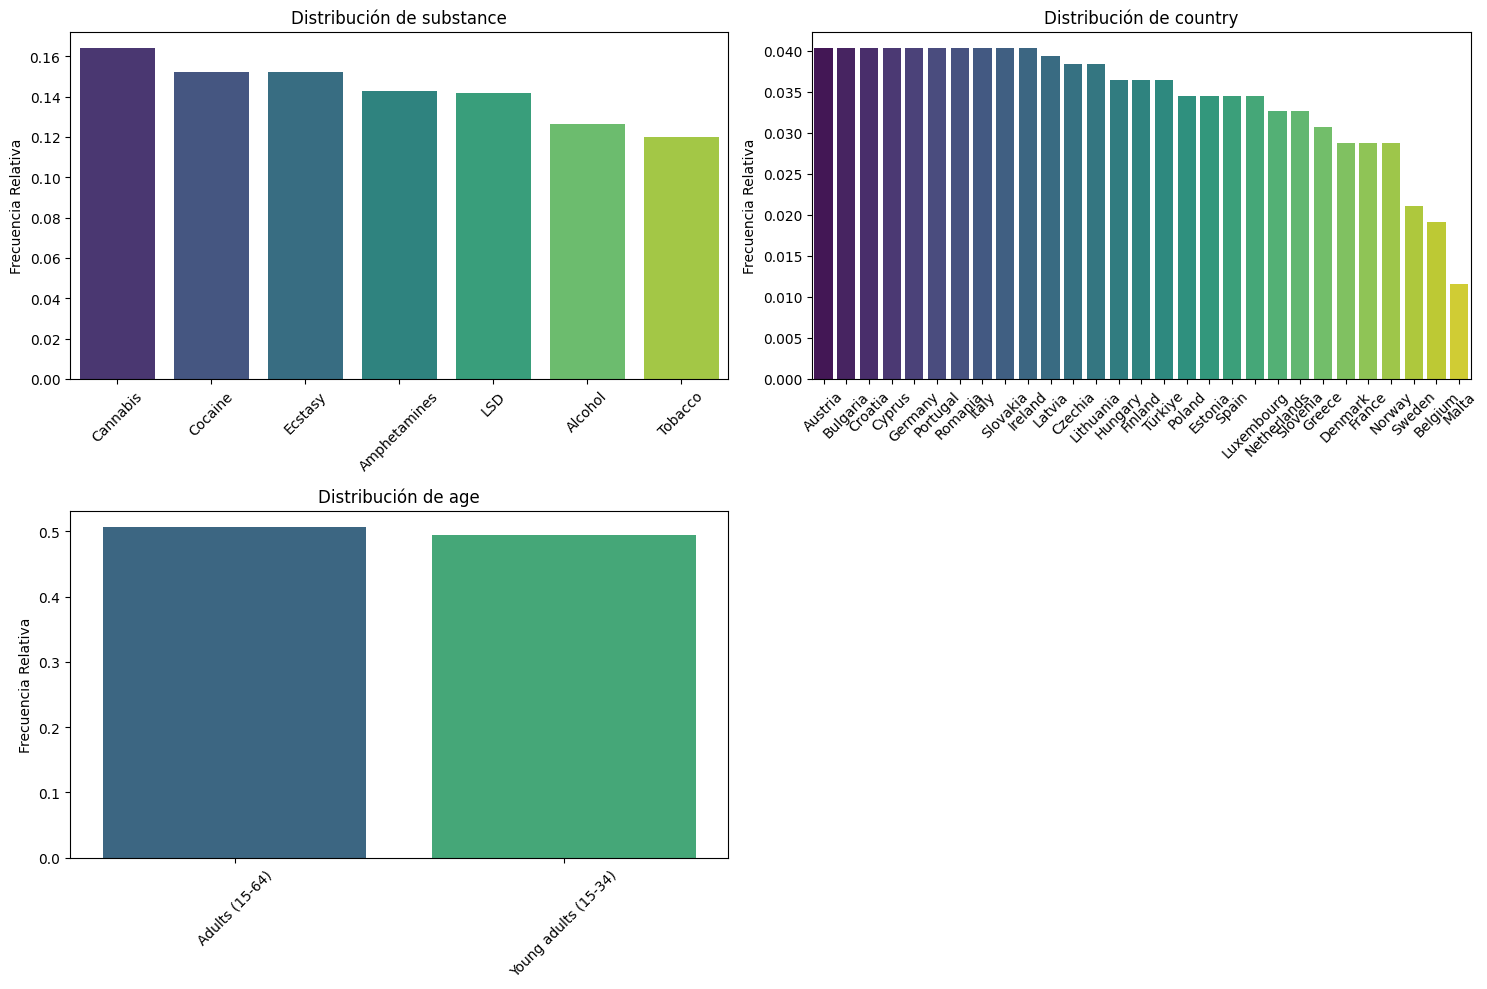

In [36]:
pinta_distribucion_categoricas(df_drugs, ["substance", "country", "age"], relativa=True)

In [16]:
df_drugs

,country,survey_year,prevalence_(%),substance,recall_period,age,sample_size,males_(%),females_(%),gender_gap
0,Austria,2020,22.7,Cannabis,Lifetime,Adults (15-64),4650.0,24.8,20.6,4.2
1,Austria,2020,27.2,Cannabis,Lifetime,Young adults (15-34),1712.0,26.8,27.6,-0.8
2,Austria,2020,6.3,Cannabis,Last year,Adults (15-64),4650.0,6.8,5.8,1.0
3,Austria,2020,11.1,Cannabis,Last year,Young adults (15-34),1712.0,10.7,11.4,-0.7
4,Austria,2020,3.6,Cannabis,Last month,Adults (15-64),4650.0,4.0,3.1,0.9
...,...,...,...,...,...,...,...,...,...,...
1038,Türkiye,2017,47.0,Tobacco,Lifetime,Young adults (15-34),NaN,61.9,33.2,28.7
1039,Türkiye,2017,33.4,Tobacco,Last year,Adults (15-64),NaN,45.0,22.5,22.5
1040,Türkiye,2017,33.2,Tobacco,Last year,Young adults (15-34),NaN,45.4,20.6,24.8
1041,Türkiye,2017,31.5,Tobacco,Last month,Adults (15-64),NaN,42.8,21.0,21.8


#### numericas

In [46]:
num_cols = columnas_numericas(df_drugs)
numeric_cols = [
    "prevalence_(%)",
    "males_(%)",
    "females_(%)",
]   

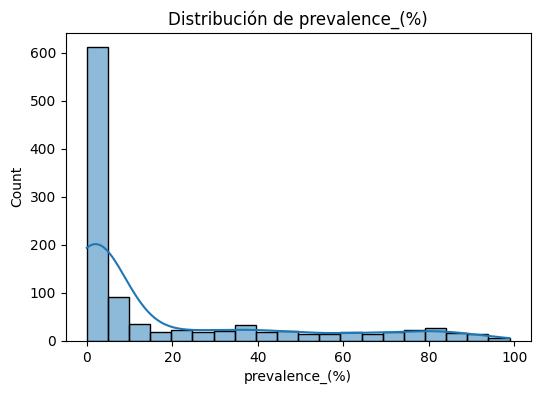

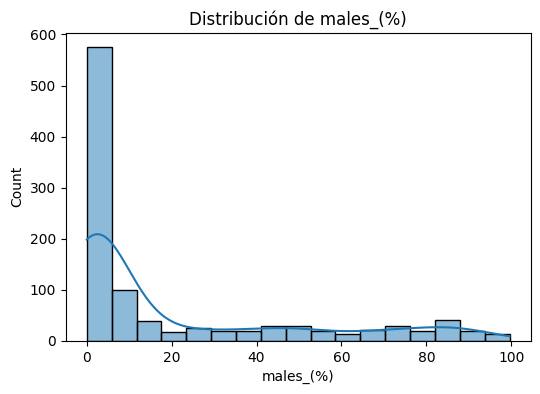

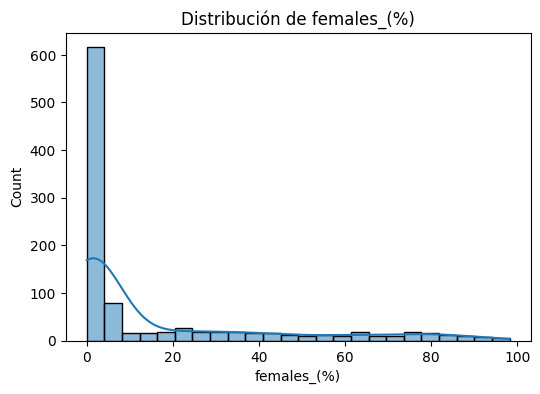

In [47]:
for col in numeric_cols:

    plt.figure(figsize=(6,4))

    sns.histplot(df_drugs[col], kde=True)

    plt.title(f"Distribución de {col}")

    plt.show()

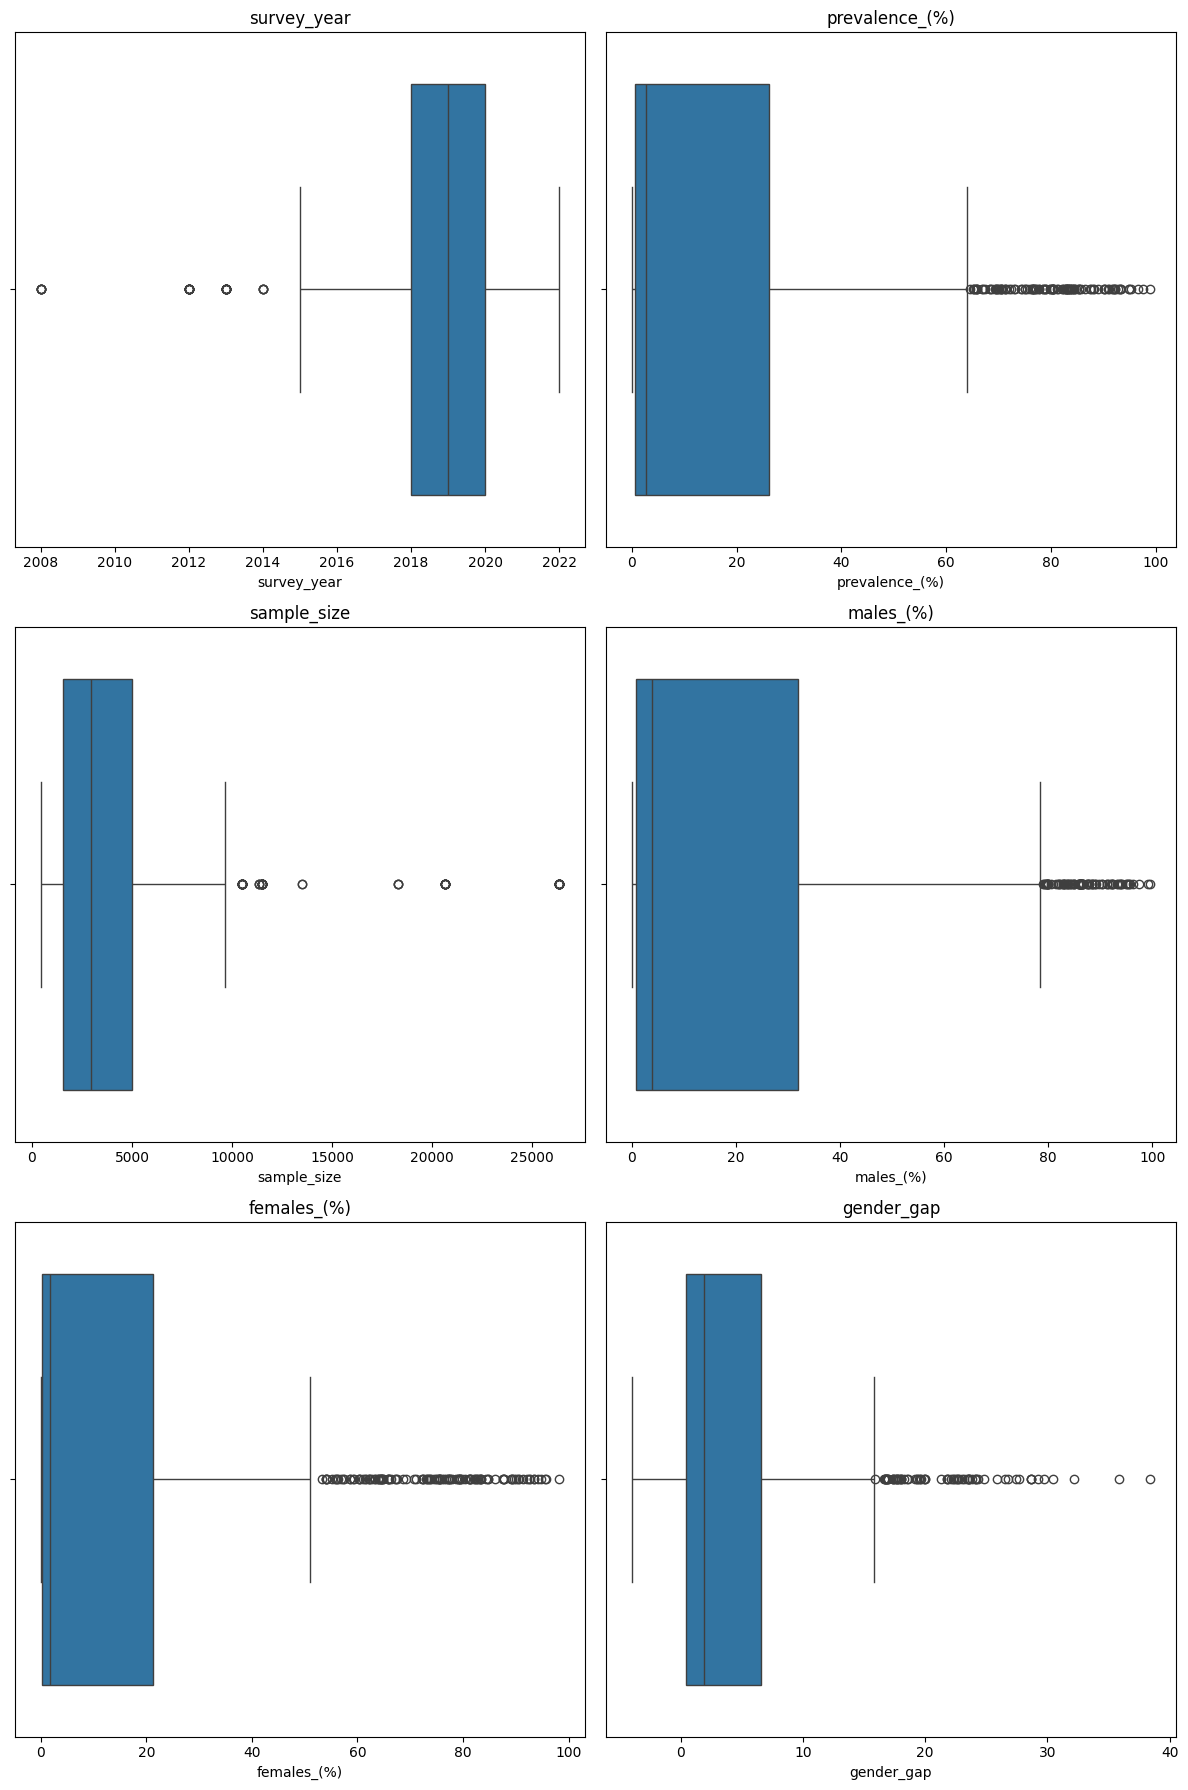

In [48]:
plot_multiple_boxplots(df_drugs, columns=num_cols)

In [49]:
df_drugs.describe().loc["max"] - df_drugs.describe().loc["min"]

survey_year          14.0
prevalence_(%)       98.9
sample_size       25902.0
males_(%)            99.6
females_(%)          98.2
gender_gap           42.4
dtype: float64

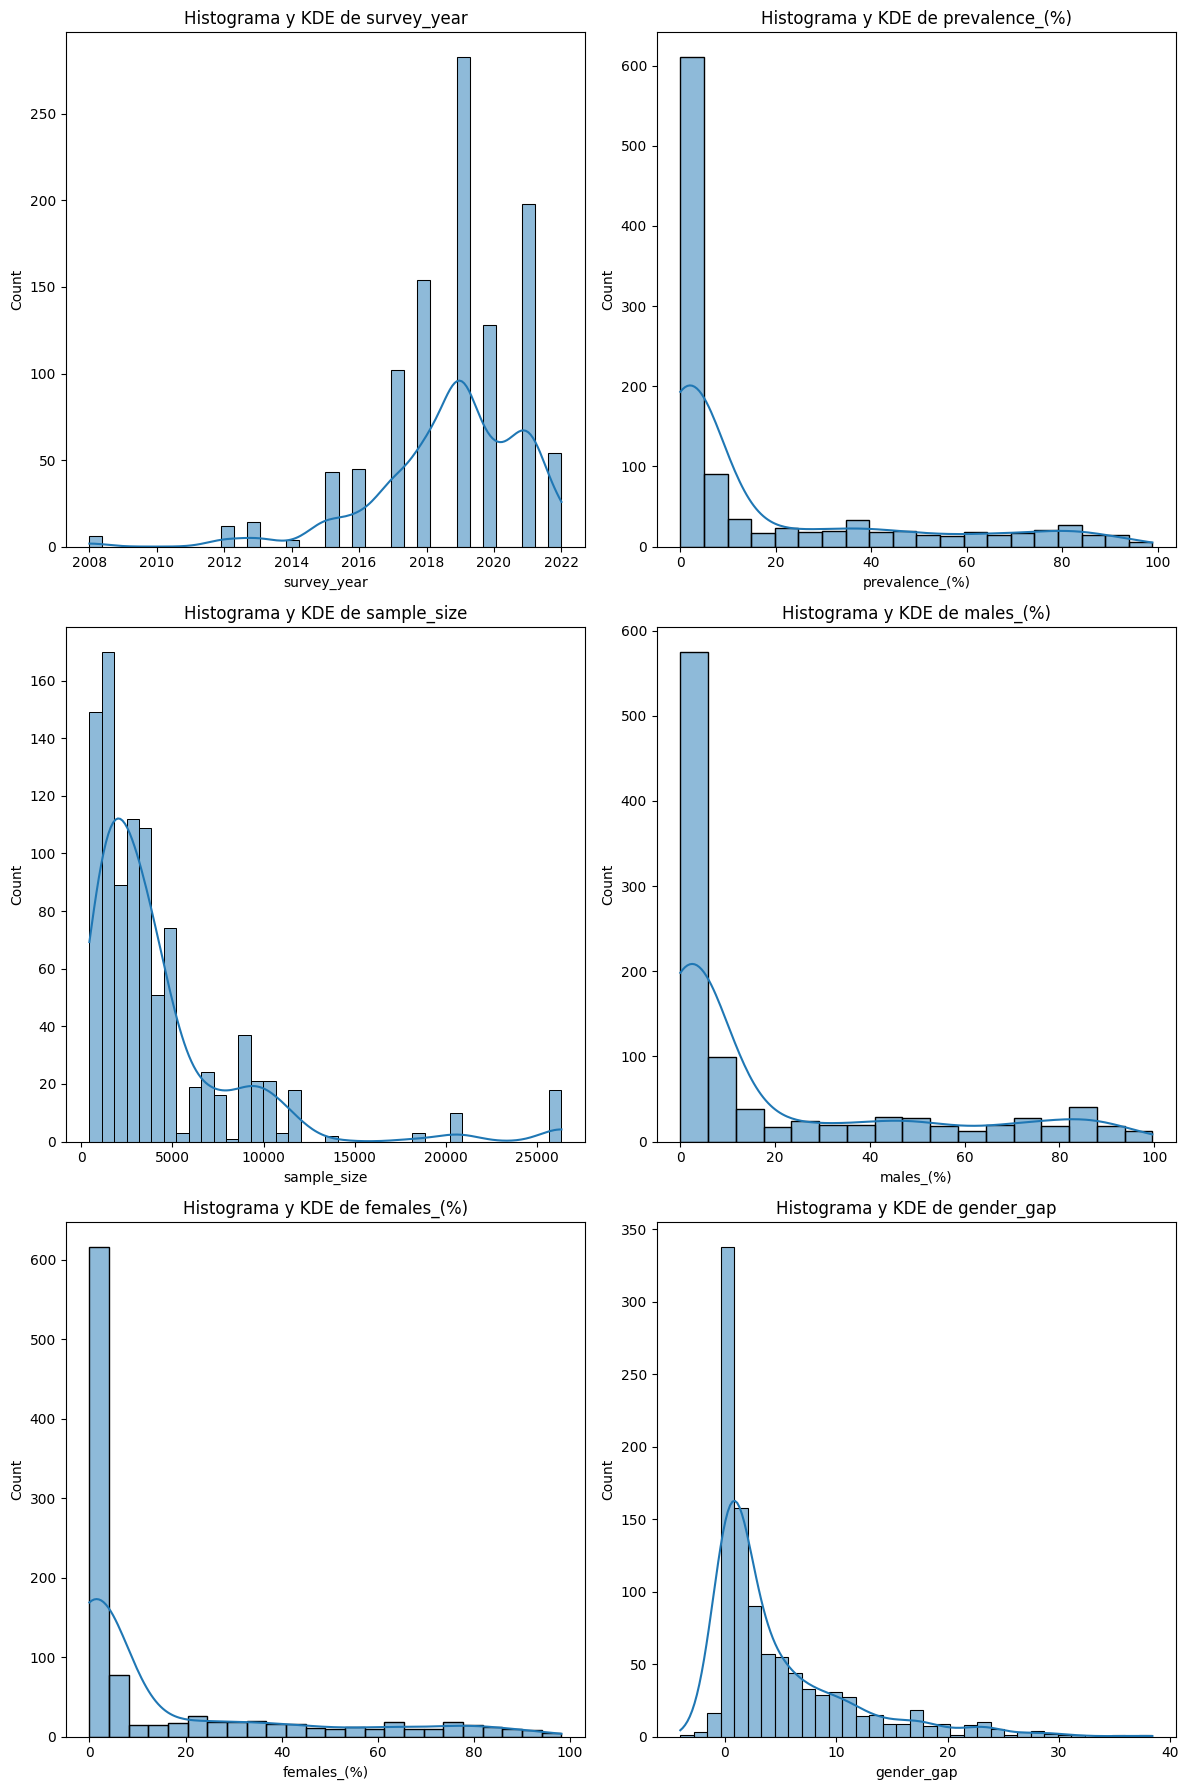

In [51]:
plot_histo_dens(df_drugs, columns=num_cols)

## ANALISIS BIVARIANTE

### **ANÁLISIS BIVARIANTE**

## me he quedado aqui

## **ANÁLISIS MULTIVARIANTE**